# EBM 1D latitudinal (climlab)

Notebook en construcción.

In [1]:
# EBM 1D latitudinal (climlab)

#Modelo de balance de energía latitudinal con ciclo estacional.

#Este notebook permite ejecutar un EBM 1D, explorar su estado estacionario estacional
#y analizar perfiles latitudinales y ciclos estacionales de temperatura superficial.

#**Instrucciones:**
#1. Ejecutar todas las celdas en orden.
#2. Modificar solo los parámetros indicados cuando se solicite.

# NOTE:
# In climlab.EBM_seasonal(), the shortwave subprocess is 'SW'
# and the effective albedo is taken from sw.albedo (array, latitudinal).
# Modifying sw.albedo directly affects ASR and surface temperature.



In [2]:
# Cell 1 — Imports and environment check
import numpy as np
import matplotlib.pyplot as plt
import climlab

print("climlab version:", climlab.__version__)


/srv/conda/envs/notebook/lib/python3.10/site-packages/climlab/radiation/cam3.py:45: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')


climlab version: 0.9.1


/srv/conda/envs/notebook/lib/python3.10/site-packages/climlab/radiation/rrtm/rrtmg_lw.py:18: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/climlab/radiation/rrtm/rrtmg_sw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/climlab/convection/emanuel_convection.py:12: UserWarning: Cannot import EmanuelConvection fortran extension, this module will not be functional.
  warnings.warn('Cannot import EmanuelConvection fortran extension, this module will not be functional.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/cli

In [3]:
# Cell 2 — Experiment parameters (pedagogical controls)

# Integration horizon
NYEARS_SPINUP = 20

# Radiative forcing (W m^-2): implemented as A -> A - F in OLR = A + B*T
F = 0.0

# Toggle for the ice–albedo feedback (black box for students)
USE_ICE_ALBEDO = True

# Ice–albedo parameters (°C)
Tf = -2.0       # transition center temperature
deltaT = 2.0    # transition half-width (smoothness)

# Albedo cap when fully ice-covered (dimensionless)
aice = 0.60


In [4]:
# Cell 3 — Robust helper utilities (no climlab subclassing)

SECONDS_PER_YEAR = 365.0 * 24.0 * 3600.0

def steps_per_year(model):
    """Compute integer steps per year from the model timestep (robust across climlab objects)."""
    dt = float(model.timestep)  # seconds
    return int(np.round(SECONDS_PER_YEAR / dt))

def smooth_ice_fraction(Tc, Tf=-2.0, deltaT=2.0):
    """
    Smooth ice fraction in [0,1] as a function of temperature (°C).
    1 ~ ice-covered, 0 ~ ice-free.
    """
    # f = 0.5*(1 - tanh((T-Tf)/deltaT)) gives a smooth step centered at Tf
    x = (Tc - Tf) / deltaT
    return 0.5 * (1.0 - np.tanh(x))

def update_sw_albedo_from_temperature(model, alpha_warm_field, aice=0.60, Tf=-2.0, deltaT=2.0):
    """
    External control of SW.albedo:
      alpha = alpha_warm + (aice - alpha_warm) * f_ice(Ts)
    where alpha_warm is the baseline latitudinal albedo provided by climlab (P2Albedo-like).
    This avoids touching subprocess architecture and is very stable.
    """
    Ts = model.state['Ts']  # climlab Field
    fice = smooth_ice_fraction(np.array(Ts), Tf=Tf, deltaT=deltaT)  # numpy array

    alpha_warm = np.array(alpha_warm_field)
    alpha_new = alpha_warm + (aice - alpha_warm) * fice

    # keep within physical bounds
    alpha_new = np.clip(alpha_new, 0.0, 1.0)

    # assign back preserving climlab Field type (template*0 + array keeps domain/shape)
    sw = model.subprocess['SW']
    sw.albedo = sw.albedo * 0.0 + alpha_new

def spinup_model(model, nyears, albedo_controller=None):
    """
    Integrate forward for nyears, optionally applying an external albedo controller each step.
    """
    nsteps = int(nyears * steps_per_year(model))
    for _ in range(nsteps):
        if albedo_controller is not None:
            albedo_controller()
        model.step_forward()
    return model


In [5]:
# Cell 4 — Build a clean EBM_seasonal model (baseline + forcing hook)

def build_ebm_seasonal(F=0.0):
    """
    Create a fresh EBM_seasonal model and apply forcing as A -> A - F in OLR = A + B*T.
    Returns: model, alpha_warm_field (baseline SW albedo field to be used as the warm-state reference).
    """
    m = climlab.EBM_seasonal()

    # Apply forcing in LW: OLR = A + B*T, so forcing F corresponds to A -> A - F
    # (positive F reduces OLR at fixed T, warming the system)
    m.subprocess['LW'].A = m.subprocess['LW'].A - F

    # Baseline latitudinal albedo pattern from climlab (warm reference)
    alpha_warm = m.subprocess['SW'].albedo.copy()

    return m, alpha_warm


# Build the "main" model instance used for the base experiment
m_base, alpha_warm_base = build_ebm_seasonal(F=F)

print("Subprocesses:", m_base.subprocess.keys())
print("SW type:", type(m_base.subprocess['SW']))
print("SW albedo field type:", type(m_base.subprocess['SW'].albedo))


Subprocesses: dict_keys(['LW', 'insolation', 'albedo', 'SW', 'diffusion'])
SW type: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
SW albedo field type: <class 'climlab.domain.field.Field'>


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


In [6]:
# Cell 5 — Spin-up experiments (base; and optional ice–albedo run)

# --- Base run (no external albedo control) ---
m0, alpha_warm0 = build_ebm_seasonal(F=F)
spinup_model(m0, NYEARS_SPINUP, albedo_controller=None)
m_base = m0  # freeze reference name; do not reuse later


# --- Ice–albedo feedback run (external control, robust) ---
m1, alpha_warm1 = build_ebm_seasonal(F=F)

if USE_ICE_ALBEDO:
    controller = lambda: update_sw_albedo_from_temperature(
        m1, alpha_warm1, aice=aice, Tf=Tf, deltaT=deltaT
    )
else:
    controller = None

spinup_model(m1, NYEARS_SPINUP, albedo_controller=controller)
m_ice = m1  # freeze reference name; do not reuse later



/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)



[BASE (no ice–albedo control)]
Ts (°C) min/max: -23.81775907095299 31.381383541918574
SW.albedo min/max: 0.20511421993391957 0.5798857800660805
ASR mean (W m^-2): 207.0635628902252
OLR mean (W m^-2): 220.51089028525377

[ICE–ALBEDO (external control)]
Ts (°C) min/max: -29.18020506618965 28.095766425577114
SW.albedo min/max: 0.20511421993396467 0.5999999999999426
ASR mean (W m^-2): 195.01228271372796
OLR mean (W m^-2): 208.51665698309384


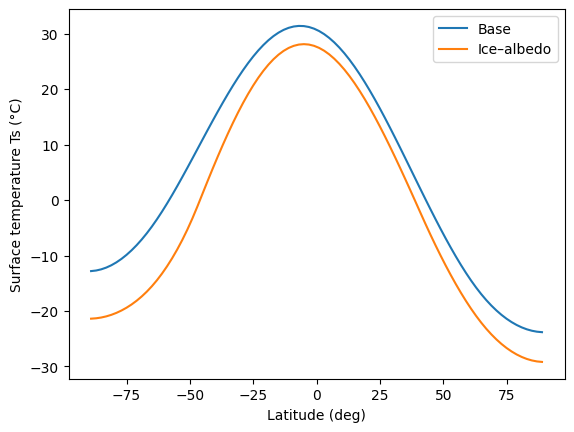

In [7]:
# Cell 6 — Hard verification (no more "0.0 / 0.0" surprises) + minimal plots

def report_albedo_and_energy(model, label="model"):
    sw = model.subprocess['SW']
    alpha_used = np.array(sw.albedo).ravel()
    Ts = np.array(model.state['Ts']).ravel()

    print(f"\n[{label}]")
    print("Ts (°C) min/max:", float(np.min(Ts)), float(np.max(Ts)))
    print("SW.albedo min/max:", float(np.min(alpha_used)), float(np.max(alpha_used)))
    print("ASR mean (W m^-2):", float(np.mean(np.array(model.diagnostics['ASR']))))
    print("OLR mean (W m^-2):", float(np.mean(np.array(model.diagnostics['OLR']))))

report_albedo_and_energy(m_base, label="BASE (no ice–albedo control)")
report_albedo_and_energy(m_ice,  label="ICE–ALBEDO (external control)")


# Quick pedagogical plot: final latitudinal Ts comparison
lat = np.array(m_base.lat)
Ts_base = np.array(m_base.state['Ts']).ravel()
Ts_ice  = np.array(m_ice.state['Ts']).ravel()

plt.figure()
plt.plot(lat, Ts_base, label="Base")
plt.plot(lat, Ts_ice,  label="Ice–albedo")
plt.xlabel("Latitude (deg)")
plt.ylabel("Surface temperature Ts (°C)")
plt.legend()
plt.show()


Initial Ts shape: (90,)
Initial Ts min/max: -27.981724810572878 31.98172481057287
First 10 Ts values: [-27.98172481 -27.83565686 -27.54423259 -27.10887179 -26.53169549
 -25.81551564 -24.96382139 -23.98076211 -22.87112718 -21.64032261]


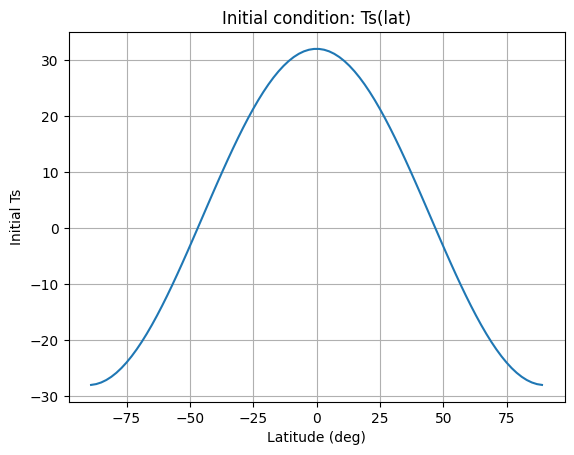

In [5]:
m = climlab.EBM_seasonal()

Ts0 = np.array(m.state['Ts']).ravel()
lat = m.state['Ts'].domain.axes['lat'].points

print("Initial Ts shape:", Ts0.shape)
print("Initial Ts min/max:", Ts0.min(), Ts0.max())
print("First 10 Ts values:", Ts0[:10])

plt.figure()
plt.plot(lat, Ts0)
plt.xlabel("Latitude (deg)")
plt.ylabel("Initial Ts")
plt.title("Initial condition: Ts(lat)")
plt.grid(True)
plt.show()


In [6]:
alb = m.subprocess['albedo']
print(type(alb))
print("Albedo subprocess attributes (subset):")
for name in ['a0', 'ai', 'aice', 'a_land', 'a_ocean', 'Tcrit', 'Tf', 'deltaT', 'param']:
    if hasattr(alb, name):
        print(name, "=", getattr(alb, name))
if hasattr(alb, 'param'):
    print("param keys:", list(alb.param.keys()))


<class 'climlab.surface.albedo.P2Albedo'>
Albedo subprocess attributes (subset):
a0 = 0.33
param = {'S0': 1365.2, 's2': -0.48, 'A': 210.0, 'B': 2.0, 'D': 0.555, 'water_depth': 10.0, 'timestep': 350632.51200000005, 'a0': 0.33, 'a2': 0.25}
param keys: ['S0', 's2', 'A', 'B', 'D', 'water_depth', 'timestep', 'a0', 'a2']


In [7]:
print("State variables:", list(m.state.keys()))
print("Diagnostics:", list(m.diagnostics.keys())[:10], "...")
print("Subprocesses:", list(m.subprocess.keys()))


State variables: ['Ts']
Diagnostics: ['OLR', 'insolation', 'coszen', 'irradiance_factor', 'icelat', 'ice_area', 'albedo', 'ASR', 'diffusive_flux', 'advective_flux'] ...
Subprocesses: ['LW', 'insolation', 'albedo', 'SW', 'diffusion']


In [8]:
# Latitude coordinate
lat = m.state['Ts'].domain.axes['lat'].points

# Time step (seconds -> days)
dt_days = m.timestep / 86400.0
nsteps_year = int(round(365.0 / dt_days))

print(f"Time step: {dt_days:.2f} days")
print(f"Steps per year: {nsteps_year}")

# Store one full seasonal cycle after spin-up
Ts_year = np.zeros((len(lat), nsteps_year))

for k in range(nsteps_year):
    m.step_forward()
    Ts_year[:, k] = np.array(m.state['Ts']).ravel()

# Annual mean temperature profile
Ts_ann = Ts_year.mean(axis=1)

# Time axis for plotting
time_days = np.arange(nsteps_year) * dt_days


Time step: 4.06 days
Steps per year: 90


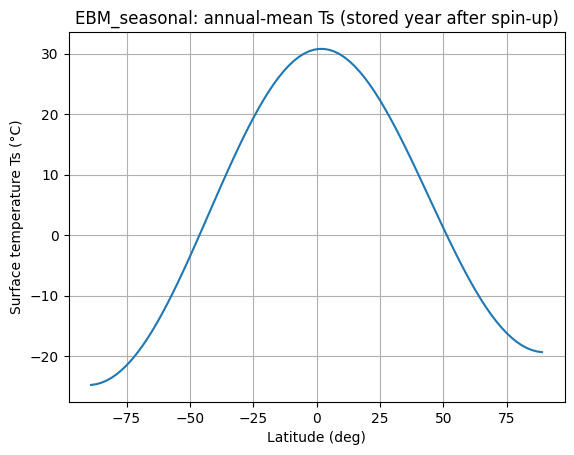

In [9]:
plt.figure()
plt.plot(lat, Ts_ann)
plt.xlabel("Latitude (deg)")
plt.ylabel("Surface temperature Ts (°C)")
plt.title("EBM_seasonal: annual-mean Ts (stored year after spin-up)")
plt.grid(True)
plt.show()


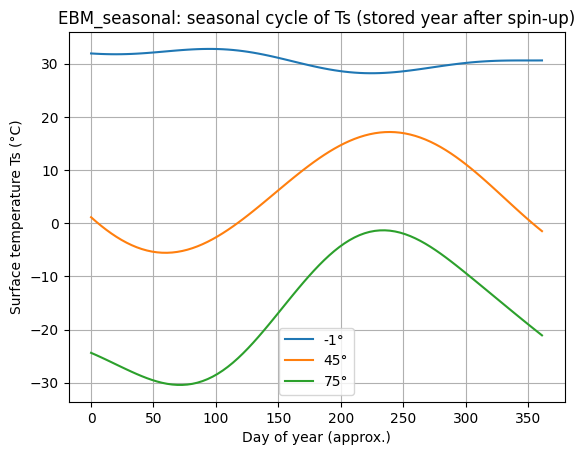

In [10]:
target_lats = [0, 45, 75]
idx = [int(np.argmin(np.abs(lat - x))) for x in target_lats]

plt.figure()
for x, i in zip(target_lats, idx):
    plt.plot(time_days, Ts_year[i, :], label=f"{lat[i]:.0f}°")

plt.xlabel("Day of year (approx.)")
plt.ylabel("Surface temperature Ts (°C)")
plt.title("EBM_seasonal: seasonal cycle of Ts (stored year after spin-up)")
plt.legend()
plt.grid(True)
plt.show()


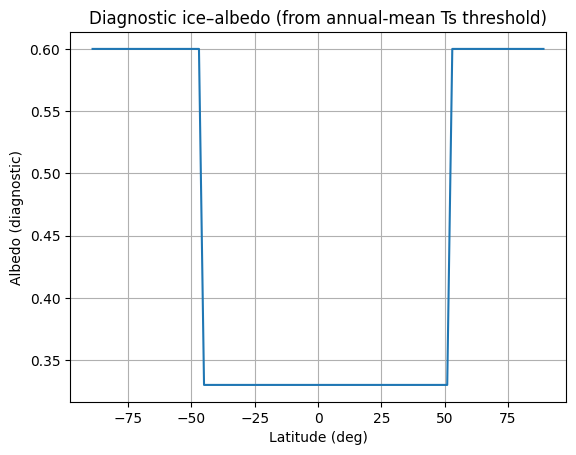

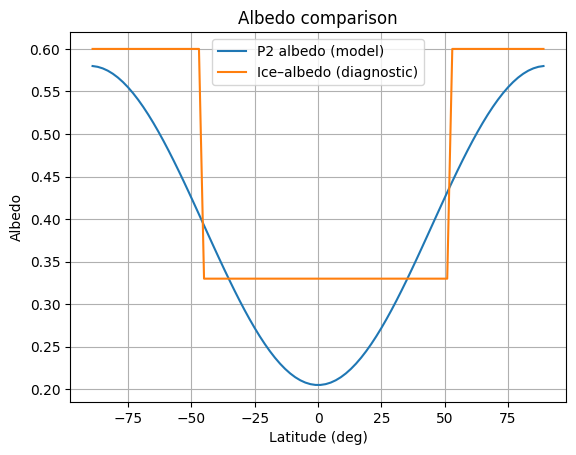

Approx. NH iceline latitude: 53.0°


In [11]:
import matplotlib.pyplot as plt

if ice_albedo_feedback:
    # Diagnostic ice mask from annual-mean temperature
    ice_mask = Ts_ann < Tf

    # Diagnostic two-state albedo
    albedo_ice = np.where(ice_mask, aice, a0)

    plt.figure()
    plt.plot(lat, albedo_ice)
    plt.xlabel("Latitude (deg)")
    plt.ylabel("Albedo (diagnostic)")
    plt.title("Diagnostic ice–albedo (from annual-mean Ts threshold)")
    plt.grid(True)
    plt.show()

    # Compare with smooth P2 albedo used in the model
    x = np.sin(np.deg2rad(lat))
    P2 = 0.5 * (3*x**2 - 1)
    albedo_p2 = a0 + a2 * P2

    plt.figure()
    plt.plot(lat, albedo_p2, label="P2 albedo (model)")
    plt.plot(lat, albedo_ice, label="Ice–albedo (diagnostic)")
    plt.xlabel("Latitude (deg)")
    plt.ylabel("Albedo")
    plt.title("Albedo comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Approximate NH iceline
    nh = lat >= 0
    Ts_nh = Ts_ann[nh]
    lat_nh = lat[nh]
    below = np.where(Ts_nh < Tf)[0]
    if len(below) == 0:
        print("No ice in NH.")
    else:
        print(f"Approx. NH iceline latitude: {lat_nh[below[0]]:.1f}°")


In [12]:
print(getattr(m.state['Ts'], "units", "unknown"))

unknown


Integrating for 1800 steps, 7304.844000000001 days, or 20 years.
Total elapsed time is 19.99999999999943 years.
Integrating for 1800 steps, 7304.844000000001 days, or 20 years.
Total elapsed time is 19.99999999999943 years.


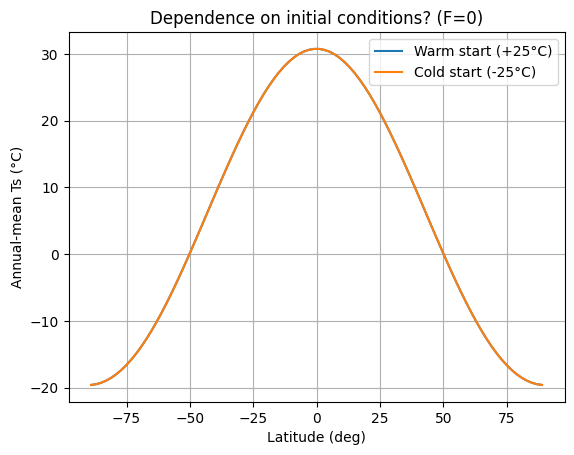

In [13]:
def run_model_with_initial_T(T_init_const, nyears, F):
    m = climlab.EBM_seasonal()

    # forcing: A -> A - F
    A_base = m.param['A']
    A_effective = A_base - F
    m.param['A'] = A_effective
    if 'LW' in m.subprocess:
        lw = m.subprocess['LW']
        if hasattr(lw, 'A'):
            lw.A = A_effective
        elif hasattr(lw, 'param') and 'A' in lw.param:
            lw.param['A'] = A_effective

    # set initial condition
    m.state['Ts'][:] = T_init_const

    # integrate
    m.integrate_years(nyears)

    # return final annual-mean Ts profile (store one year)
    lat = m.state['Ts'].domain.axes['lat'].points
    dt_days = m.timestep / 86400.0
    nsteps_year = int(round(365.0 / dt_days))
    Ts_year = np.zeros((len(lat), nsteps_year))
    for k in range(nsteps_year):
        m.step_forward()
        Ts_year[:, k] = np.array(m.state['Ts']).ravel()
    Ts_ann = Ts_year.mean(axis=1)
    return lat, Ts_ann

lat, Ts_warm = run_model_with_initial_T(25.0, nyears=20, F=0.0)
_,   Ts_cold = run_model_with_initial_T(-25.0, nyears=20, F=0.0)

plt.figure()
plt.plot(lat, Ts_warm, label="Warm start (+25°C)")
plt.plot(lat, Ts_cold, label="Cold start (-25°C)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Annual-mean Ts (°C)")
plt.title("Dependence on initial conditions? (F=0)")
plt.legend()
plt.grid(True)
plt.show()


Integrating for 4500 steps, 18262.11 days, or 50 years.
Total elapsed time is 50.00000000000431 years.
Integrating for 4500 steps, 18262.11 days, or 50 years.
Total elapsed time is 50.00000000000431 years.


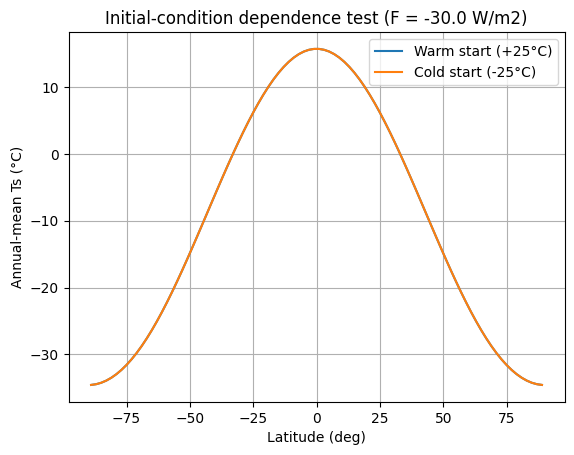

Warm/cold global-mean Ts (annual): -9.965079491655446 -9.965079491655446


In [9]:
def build_model(F, nyears, T_init):
    m = climlab.EBM_seasonal()

    # Forcing: A -> A - F
    A_base = m.param['A']
    A_effective = A_base - F
    m.param['A'] = A_effective
    if 'LW' in m.subprocess:
        lw = m.subprocess['LW']
        if hasattr(lw, 'A'):
            lw.A = A_effective
        elif hasattr(lw, 'param') and 'A' in lw.param:
            lw.param['A'] = A_effective

    # Replace albedo subprocess with dynamic one
    if 'albedo' in m.subprocess:
        m.remove_subprocess('albedo')
    alb = DynamicIceAlbedo(state=m.state, a0=a0, a2=a2, aice=aice, Tf=Tf, deltaT=deltaT, timestep=m.timestep)
    m.add_subprocess('albedo', alb)

    # Initial condition
    m.state['Ts'][:] = T_init

    # Spin-up
    m.integrate_years(nyears)
    return m

def annual_mean_Ts(m):
    lat = m.state['Ts'].domain.axes['lat'].points
    dt_days = m.timestep / 86400.0
    nsteps_year = int(round(365.0 / dt_days))
    Ts_year = np.zeros((len(lat), nsteps_year))
    for k in range(nsteps_year):
        m.step_forward()
        Ts_year[:, k] = np.array(m.state['Ts']).ravel()
    Ts_ann = Ts_year.mean(axis=1)
    return lat, Ts_ann

# --- Try a cold forcing ---
F_test = -30.0     # if no separation, try -20 or -30
nyears_test = 50

m_warm = build_model(F=F_test, nyears=nyears_test, T_init=25.0)
m_cold = build_model(F=F_test, nyears=nyears_test, T_init=-25.0)

lat, Ts_warm = annual_mean_Ts(m_warm)
_,   Ts_cold = annual_mean_Ts(m_cold)

plt.figure()
plt.plot(lat, Ts_warm, label="Warm start (+25°C)")
plt.plot(lat, Ts_cold, label="Cold start (-25°C)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Annual-mean Ts (°C)")
plt.title(f"Initial-condition dependence test (F = {F_test} W/m2)")
plt.legend()
plt.grid(True)
plt.show()

print("Warm/cold global-mean Ts (annual):",
      Ts_warm.mean(), Ts_cold.mean())
